In [1]:
import matplotlib.pyplot as plt
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints, JulierSigmaPoints
from filterpy.kalman import unscented_transform
import autograd.numpy as np
from autograd import jacobian, hessian
import scipy

In [4]:
def is_positive_definite(A):
    try:
        scipy.linalg.cholesky(A)
        return True
    except:
        return False
def kl_divergence_gaussian(mu_p, Sigma_p, mu_q, Sigma_q):
    """
    Compute KL divergence of two multivariate Gaussian distributions.
    KL(p||q) for Gaussian p(mu_p, Sigma_p) and q(mu_q, Sigma_q)
    """
    k = len(mu_p)
    Sigma_q_inv = np.linalg.inv(Sigma_q)

    kl_div = 0.5 * (np.trace(Sigma_q_inv @ Sigma_p)
                    + (mu_q - mu_p).T @ Sigma_q_inv @ (mu_q - mu_p)
                    - k
                    + np.log(np.linalg.det(Sigma_q) / np.linalg.det(Sigma_p)))
    return kl_div

In [3]:
def f(x, dt):
    return [x[0] + x[2] * dt, x[1] + x[3] * dt, x[2], x[3]]


# 非线性观测函数
def h(x):
    r = np.sqrt(x[0] ** 2 + x[1] ** 2)
    theta = np.arctan2(x[1], x[0])
    return [r, theta]

In [5]:
def plf_update(x_prior, P_prior, R, z):
    x_hat = x_prior
    P_hat = P_prior
    x_hat_old = 100 * np.ones_like(x_prior)
    P_hat_old = 100 * np.eye(4)
    ite = 0
    while kl_divergence_gaussian(x_hat_old, P_hat_old, x_hat, P_hat) >= 1e-2 and ite <= 100:
        ite += 1
        x_hat_old = x_hat
        P_hat_old = P_hat
        points_linear = MerweScaledSigmaPoints(n=4, alpha=1e-3, beta=2., kappa=0.)
        sigmas = points_linear.sigma_points(x_hat, P_hat)
        sigmas_h = np.empty((9, 2))
        for i in range(sigmas.shape[0]):
            sigmas_h[i] = h(sigmas[i])
        zp, Pz = unscented_transform(sigmas_h, points_linear.Wm, points_linear.Wc, noise_cov=None)
        Pxz = np.zeros((4, 2))
        for i in range(sigmas.shape[0]):
            Pxz += points_linear.Wc[i] * np.outer(sigmas[i] - x_hat, sigmas_h[i] - zp)

        H = Pxz.T @ np.linalg.inv(P_hat)
        b = zp - H @ x_hat
        Omega = Pz - H @ P_hat @ H.T

        x_hat = x_prior + P_prior @ H.T @ np.linalg.inv(H @ P_prior @ H.T + Omega + R) @ (z - H @ x_prior - b)
        P_hat = P_prior - P_prior @ H.T @ np.linalg.inv(H @ P_prior @ H.T + Omega + R) @ H @ P_prior

    return x_hat, P_hat


def rplf_update(x_prior, P_prior, R, z):
    x_hat = x_prior
    P_hat = P_prior
    x_hat_old = 100 * np.ones_like(x_prior)
    P_hat_old = 100 * np.eye(4)
    ite = 0
    alpha = 0.8
    while kl_divergence_gaussian(x_hat_old, P_hat_old, x_hat, P_hat) >= 1e-2 and ite <= 100:
        ite += 1
        x_hat_old = x_hat
        P_hat_old = P_hat
        points_linear = MerweScaledSigmaPoints(n=4, alpha=1e-3, beta=2., kappa=0.)
        sigmas = points_linear.sigma_points(x_hat, P_hat)
        sigmas_h = np.empty((9, 2))
        for i in range(sigmas.shape[0]):
            sigmas_h[i] = h(sigmas[i])
        zp, Pz = unscented_transform(sigmas_h, points_linear.Wm, points_linear.Wc, noise_cov=None)
        Pxz = np.zeros((4, 2))
        for i in range(sigmas.shape[0]):
            Pxz += points_linear.Wc[i] * np.outer(sigmas[i] - x_hat, sigmas_h[i] - zp)

        H = Pxz.T @ np.linalg.inv(P_hat)
        b = zp - H @ x_hat
        Omega = Pz - H @ P_hat @ H.T

        x_hat = x_prior + alpha*P_prior @ H.T @ np.linalg.inv(H @ P_prior @ H.T + Omega + R) @ (z - H @ x_prior - b)
        P_hat = P_prior - P_prior @ H.T @ np.linalg.inv(H @ P_prior @ H.T + (Omega + R) / alpha ) @ H @ P_prior

    return x_hat, P_hat

In [6]:
# 创建sigma点
points1 = MerweScaledSigmaPoints(n=4, alpha=1e-3, beta=2., kappa=0.)
points2 = MerweScaledSigmaPoints(n=4, alpha=1e-3, beta=2., kappa=0.)
points3 = MerweScaledSigmaPoints(n=4, alpha=1e-3, beta=2., kappa=0.)

# 创建UKF滤波器
ukf = UKF(dim_x=4, dim_z=2, dt=0.1, fx=f, hx=h, points=points1)
ukf.x = np.array([0., 0., 1., 1.])
ukf.P *= 1
ukf.R = np.diag([0.01, 0.01])
ukf.Q = np.diag([1, 1, 0.01, 0.01])

plf = UKF(dim_x=4, dim_z=2, dt=0.1, fx=f, hx=h, points=points2)
plf.x = np.array([0., 0., 1., 1.])
plf.P *= 1
plf.R = np.diag([0.01, 0.01])
plf.Q = np.diag([1, 1, 0.01, 0.01])

rplf = UKF(dim_x=4, dim_z=2, dt=0.1, fx=f, hx=h, points=points3)
rplf.x = np.array([0., 0., 1., 1.])
rplf.P *= 1
rplf.R = np.diag([0.01, 0.01])
rplf.Q = np.diag([1, 1, 0.01, 0.01])

In [7]:
# 生成真实状态和观测数据
num_steps = 100
true_states = []
observations = []
state = np.array([0., 0., 1., 1.])
for _ in range(num_steps):
    state = f(state, 0.1) + np.random.multivariate_normal(mean=[0, 0, 0, 0], cov=ukf.Q)  # 加入一些噪声
    true_states.append(state)

    observation = h(state) + 0.9 * np.random.multivariate_normal(mean=[0, 0],
                                                                 cov=ukf.R) + 0.1 * np.random.multivariate_normal(
        mean=[0, 0], cov=10 * ukf.R)  # 生成观测值并加入噪声

    observations.append(observation)

true_states = np.array(true_states)

In [8]:
# 使用UKF进行状态估计
xs_ukf = []  # 保存估计的状态
xs_plf = []
xs_rplf = []
for z in observations:
    ukf.predict()
    ukf.update(z)

    plf.predict()
    x_pos_plf, P_pos_plf = plf_update(plf.x, plf.P, plf.R, z)
    plf.x = x_pos_plf.copy()
    plf.P = P_pos_plf.copy()

    rplf.predict()
    x_pos_rplf, P_pos_rplf = rplf_update(rplf.x, rplf.P, rplf.R, z)
    rplf.x = x_pos_rplf.copy()
    rplf.P = P_pos_rplf.copy()

    xs_ukf.append(ukf.x.copy())
    xs_plf.append(plf.x.copy())
    xs_rplf.append(rplf.x.copy())

xs_ukf = np.array(xs_ukf)
xs_plf = np.array(xs_plf)
xs_rplf = np.array(xs_rplf)
observations = np.array(observations)

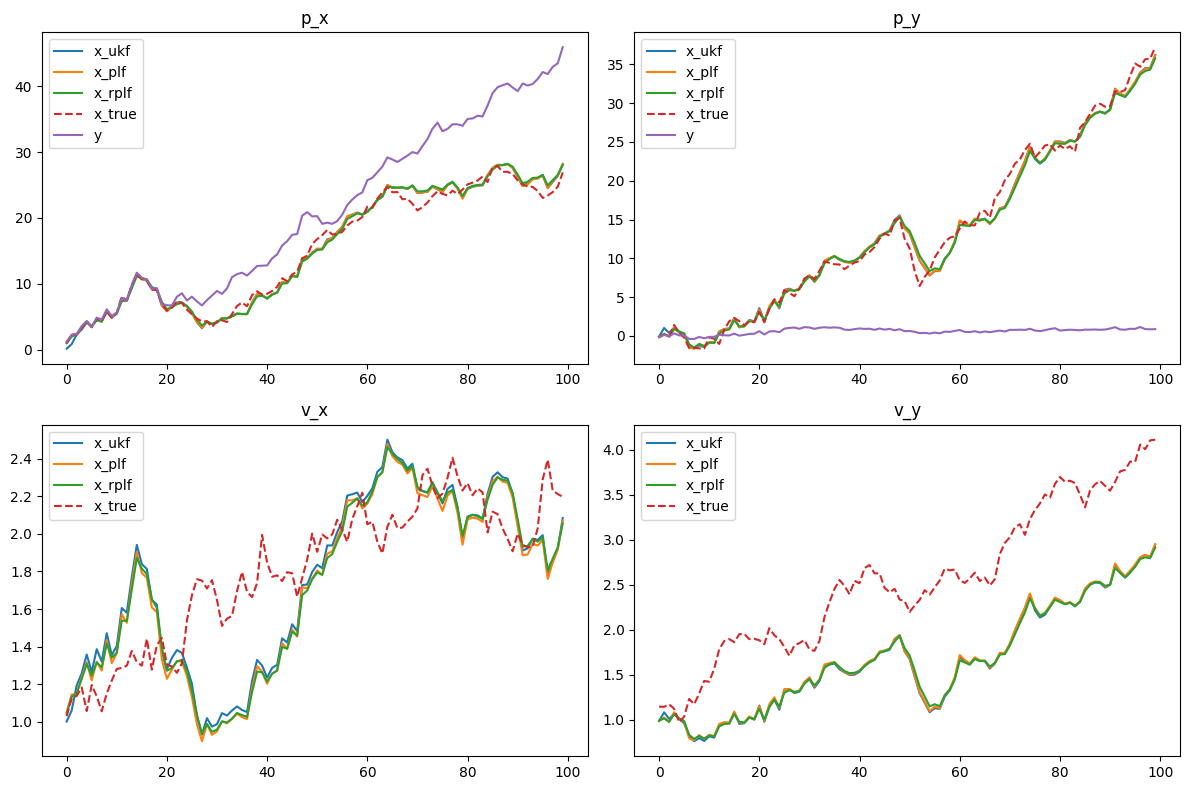

In [9]:
labels = ['p_x', 'p_y', 'v_x', 'v_y']
plt.figure(figsize=(12, 8))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(xs_ukf[:, i], label='x_ukf')
    plt.plot(xs_plf[:, i], label='x_plf')
    plt.plot(xs_rplf[:, i], label='x_rplf')
    plt.plot(true_states[:, i], label='x_true', linestyle='--')
    if i < 2:
        plt.plot(observations[:, i], label='y')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

In [10]:
def compute_rmse(predictions, true_values):
    """
    Compute the Root Mean Square Error (RMSE) between predictions and true values.
    """
    return np.sqrt(((predictions - true_values) ** 2).mean(axis=0))


# Compute RMSE for each method
rmse_ukf = compute_rmse(xs_ukf, true_states)
rmse_plf = compute_rmse(xs_plf, true_states)
rmse_rplf = compute_rmse(xs_rplf, true_states)
print("rmse_ukf", rmse_ukf)
print("rmse_plf", rmse_plf)
print("rmse_rplf", rmse_rplf)

rmse_ukf [1.02148049 1.17187351 0.33929372 0.94898696]
rmse_plf [1.00310778 1.16139031 0.3470374  0.93871836]
rmse_rplf [1.05789356 1.26425213 0.342156   0.94657039]
